# DevTools Protocol 로 네트워크 recieve 정보 가져오기

# 1) MIMI Type 별 리소스 크기 가져오기 (정확히 타입 구분가능)
# 2)encodingDataLength로 리소스 크기 가져오기 

url: https://www.naver.com/, MIME Type: text/html, Size: 389 bytes
url: https://ssl.pstatic.net/sstatic/search/pc/css/sp_autocomplete_240725.css, MIME Type: text/css, Size: 6055 bytes
url: https://ssl.pstatic.net/tveta/libs/ndpsdk/prod/ndp-loader.js, MIME Type: application/javascript, Size: 850 bytes
url: https://pm.pstatic.net/resources/css/main.6efa9308.css, MIME Type: text/css, Size: 5718 bytes
url: https://ssl.pstatic.net/tveta/libs/glad/prod/gfp-core.js, MIME Type: application/javascript, Size: 1287 bytes
url: https://ssl.pstatic.net/tveta/libs/assets/js/pc/main/min/pc.veta.core.min.js, MIME Type: application/javascript, Size: 1287 bytes
url: https://pm.pstatic.net/resources/js/polyfill.a163af38.js?o=www, MIME Type: application/javascript, Size: 23608 bytes
url: https://ssl.pstatic.net/tveta/libs/ndpsdk/prod/ndp-core.js, MIME Type: application/javascript, Size: 29745 bytes
url: https://pm.pstatic.net/resources/js/main.7e5082d3.js?o=www, MIME Type: application/javascript, Size: 782
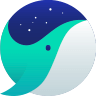
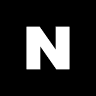

In [19]:
import chromedriver_autoinstaller
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
import json
import time
# 크롬 드라이버 자동 설치
chromedriver_autoinstaller.install()

# 크롬 옵션 설정
options = Options()
options.set_capability('goog:loggingPrefs', {'performance': 'ALL'})
options.add_argument('--headless')  # 브라우저를 표시하지 않고 실행
options.add_argument('--disable-web-security')  # CORS 정책 우회 설정
options.add_argument('--ignore-certificate-errors')  # SSL 인증서 무시 설정

# 드라이버 초기화
driver = webdriver.Chrome(options=options)

# 네트워크 로그 수집
driver.get('https://naver.com')  # 대상 웹사이트로 변경

resource_types = {'Document': 0, 'Stylesheet': 0, 'Script': 0, 'Image': 0, 'Media': 0, 'Other': 0}
total_size = 0

for log in driver.get_log('performance'):
    message = json.loads(log["message"])["message"]
    if "Network.responseReceived" == message["method"]: # event는 log에 method로 기록되어있음
        mime_type = message['params']['response']['mimeType'] # MIME 타입
        resource_size = message['params']['response']['encodedDataLength'] # encodedDataLength로 리소스 사이즈 가져오기
        url = message['params']['response']['url']
        
        # MIME 타입에 따라 resource_size 리소스 유형을 분류 및 합산
        if 'text/html' in mime_type:
            resource_types['Document'] += resource_size
        elif 'text/css' in mime_type:
            resource_types['Stylesheet'] += resource_size
        elif 'application/javascript' in mime_type or 'application/x-javascript' in mime_type or 'text/javascript' in mime_type:
            resource_types['Script'] += resource_size
        elif 'image' in mime_type or ('application/octet-stream' in mime_type and ('.png' in url or '.jpg' in url or '.jpeg' in url or '.gif' in url)):  # 추가 조건
            resource_types['Image'] += resource_size
        elif 'video' in mime_type or 'audio' in mime_type:
            resource_types['Media'] += resource_size
        else:
            resource_types['Other'] += resource_size
        time.sleep(0.1)
        total_size += resource_size
        print(f"url: {url}, MIME Type: {mime_type}, Size: {resource_size} bytes")

# 드라이버 종료
driver.quit()

# 결과 출력
print("Resource Sizes:")
for resource_type, size in resource_types.items():
    print(f"{resource_type}: {size} bytes")

print(f"Total Network Size: {total_size} bytes")

# 탄소 배출량 추정 (1GB = 0.06kg CO2)
total_size_gb = total_size / (1024 ** 3)
carbon_emission = total_size_gb * 0.06
print(f"Estimated Carbon Emission: {carbon_emission:.6f} kg CO2")
